(lp_intro)=
# 线性规划

在本讲中，我们将需要以下库。使用 `pip` 安装 [ortools](https://developers.google.com/optimization)。

In [1]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/28.1 MB 7.5 MB/s eta 0:00:04

   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/28.1 MB 30.9 MB/s eta 0:00:01

   ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/28.1 MB 84.9 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 23.0/28.1 MB 206.7 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 28.1/28.1 MB 208.7 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 35.5 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 57.7 MB/s eta 0:00:00


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompatible.


## 概述

**线性规划** 问题旨在在一组线性等式和/或不等式约束下，最大化或最小化一个线性目标函数。

线性程序成对出现：

* 一个原始的 **原始** 问题，以及

* 一个相关的 **对偶** 问题。

如果原始问题涉及 *最大化*，则对偶问题涉及 *最小化*。

如果原始问题涉及 *最小化*，则对偶问题涉及 *最大化*。

我们提供线性程序的标准形式，以及将其他形式的线性规划问题转化为标准形式的方法。

我们将说明如何使用 [SciPy](https://scipy.org/) 和 [Google OR-Tools](https://developers.google.com/optimization) 来解决线性规划问题。


```{seealso}
在另一讲中，我们将使用线性规划方法来解决 {doc}`最优运输问题 <tools:opt_transport>`。
```

让我们先进行一些标准的导入。

In [2]:
import numpy as np
from ortools.linear_solver import pywraplp
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

让我们从一些线性规划问题的例子开始。

## 示例 1：生产问题

这个例子由 {cite}`bertsimas_tsitsiklis1997` 创建。

假设一个工厂可以生产两种商品，称为产品 $1$ 和产品 $2$。

生产每种产品都需要材料和劳动。

销售每种产品会产生收入。

每单位所需的材料和劳动投入及其收入如下表所示：

|          | 产品 1 | 产品 2 |
| :------: | :----: | :----: |
| 材料     |   2    |   5    |
| 劳动     |   4    |   2    |
| 收入     |   3    |   4    |

可用的材料为 30 单位，劳动为 20 单位。

公司的问题是构建一个生产计划，利用其 30 单位的材料和 20 单位的劳动来最大化其收入。

令 $x_i$ 表示公司生产的产品 $i$ 的数量，$z$ 表示总收入。

该问题可以表述为：

$$
\begin{aligned}
\max_{x_1,x_2} \ & z = 3 x_1 + 4 x_2 \\
\mbox{受以下约束 } \ & 2 x_1 + 5 x_2 \le 30 \\
& 4 x_1 + 2 x_2 \le 20 \\
& x_1, x_2 \ge 0 \\
\end{aligned}
$$

下图说明了公司的约束条件和等收入线。

等收入线显示了产生相同收入的材料和劳动的所有组合。

/home/runner/miniconda3/envs/quantecon/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.11/site-packages/IPython/core/pylabtools.

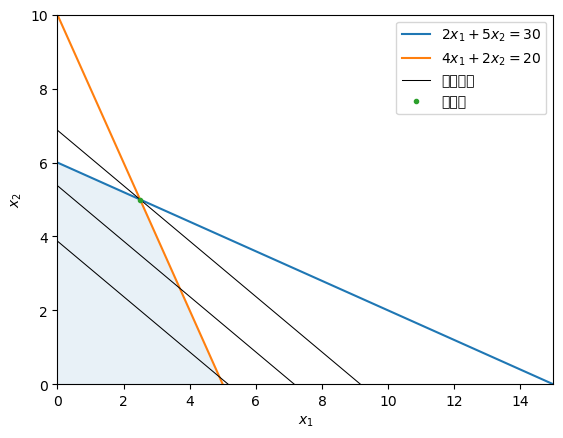

In [3]:
fig, ax = plt.subplots()
#绘制约束
ax.set_xlim(0,15)
ax.set_ylim(0,10)
x1 = np.linspace(0, 15)
ax.plot(x1, 6-0.4*x1, label="$2x_1 + 5x_2=30$")
ax.plot(x1, 10-2*x1, label="$4x_1 + 2x_2=20$")


# 绘制可行区域
feasible_set = Polygon(np.array([[0, 0],[0, 6],[2.5, 5],[5, 0]]), alpha=0.1)
ax.add_patch(feasible_set)

# 绘制目标函数
ax.plot(x1, 3.875-0.75*x1, label="等收入线",color='k',linewidth=0.75)
ax.plot(x1, 5.375-0.75*x1, color='k',linewidth=0.75)
ax.plot(x1, 6.875-0.75*x1, color='k',linewidth=0.75)

# 绘制最优解
ax.plot(2.5, 5, ".", label="最优解")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend()

plt.show()

蓝色区域是可行集合，在该集合内所有约束都得到了满足。

平行的黑线是等收入线。

公司的目标是找到与可行集合上边界平行的黑线。

可行集合与最高黑线的交点界定了最优集合。

在这个例子中，最优集合是点 $(2.5, 5)$。

### 计算：使用 OR-Tools

让我们尝试使用 `ortools.linear_solver` 包来解决同样的问题。

下面的单元格实例化一个求解器，并创建两个变量，指定它们可以具有的值范围。

In [4]:
# 实例化一个 GLOP（Google 线性优化包）求解器。
solver = pywraplp.Solver.CreateSolver('GLOP')

让我们创建两个变量 $x_1$ 和 $x_2$，使它们只能取非负值。

In [5]:
# 创建这两个变量，并让它们可以取任何非负值。
x1 = solver.NumVar(0, solver.infinity(), 'x1')
x2 = solver.NumVar(0, solver.infinity(), 'x2')

向问题中添加约束条件。

In [6]:
# 约束 1: 2x_1 + 5x_2 <= 30.0
solver.Add(2 * x1 + 5 * x2 <= 30.0)

# 约束 2: 4x_1 + 2x_2 <= 20.0
solver.Add(4 * x1 + 2 * x2 <= 20.0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f271938fd20> >

让我们指定目标函数。我们在希望最大化目标函数时使用 `solver.Maximize` 方法，而在希望最小化时可以使用 `solver.Minimize`。

In [7]:
# 目标函数: 3x_1 + 4x_2
solver.Maximize(3 * x1 + 4 * x2)

一旦我们解决了问题，就可以检查求解器是否成功解决了问题，方法是查看其状态。如果成功，则状态将等于 `pywraplp.Solver.OPTIMAL`。

In [8]:
# 求解系统
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print(f'(x1, x2): ({x1.solution_value():.2}, {x2.solution_value():.2})')
else:
    print('该问题没有最优解。')

Objective value = 27.5
(x1, x2): (2.5, 5.0)


## 示例 2：投资问题

我们现在考虑一个由 {cite}`hu_guo2018` 提出的并解决的问题。

一个共同基金有 $100,000 美元$ 可在三年内投资。

有三种投资选择可供选择：

1. 年金：基金可以在每年的开始支付相同金额的新资本，并在第三年末获得投资总资本的130\%的收益。一旦共同基金决定投资于此年金，它必须在三年内持续投资。

2. 银行账户：基金可以在每年的开始存入任何金额，并在该年末获得其资本加上6\%的利息。此外，共同基金被允许每年在开始时借款不超过 $20,000，并被要求在年末偿还借款金额加上6\%的利息。共同基金可以选择在每年的开始存款或借款。

3. 企业债券：在第二年的开始，企业债券变得可用。基金可以在第二年开始时购买不超过 $50,000 美元的债券，并在第三年末获得130\%的投资回报。

共同基金的目标是在第三年末最大化其拥有的总回报。

我们可以将此表述为一个线性规划问题。

让 $x_1$ 表示投入年金的金额，$x_2, x_3, x_4$ 表示三年初的银行存款余额，$x_5$ 表示投资于企业债券的金额。

当 $x_2, x_3, x_4$ 为负时，意味着共同基金从银行借款。

下表展示了共同基金的决策变量以及上述时序协议：

|                | 第1年 | 第2年 | 第3年 |
| :------------: | :----: | :----: | :----: |
|    年金       | $x_1$  | $x_1$  | $x_1$  |
|  银行账户     | $x_2$  | $x_3$  | $x_4$  |
| 企业债券      |   0    | $x_5$  |   0    |

共同基金的决策过程遵循以下时序协议：

1. 在第一年的开始，共同基金决定投资多少在年金中，存入银行多少。该决策受以下约束：

   $$
   x_1 + x_2 = 100,000
   $$

2. 在第二年的开始，共同基金的银行余额为 $1.06 x_2$。它必须在年金中保留 $x_1$。它可以选择将 $x_5$ 投入企业债券，并将 $x_3$ 存入银行。这些决策受以下约束：

   $$
   x_1 + x_5 = 1.06 x_2 - x_3
   $$

3. 在第三年的开始，共同基金的银行账户余额等于 $1.06 x_3$。它必须再次投资 $x_1$ 在年金中，留下银行账户余额为 $x_4$。这种情况可以用以下约束来总结：

   $$
   x_1 = 1.06 x_3 - x_4
   $$

共同基金的目标函数，即其在第三年末的财富为：

$$
1.30 \cdot 3x_1 + 1.06 x_4 + 1.30 x_5
$$

因此，共同基金面临的线性规划为：

$$
\begin{aligned}
\max_{x} \ & 1.30 \cdot 3x_1 + 1.06 x_4 + 1.30 x_5 \\
\mbox{受以下约束 } \ & x_1 + x_2 = 100,000\\
 & x_1 - 1.06 x_2 + x_3 + x_5 = 0\\
 & x_1 - 1.06 x_3 + x_4 = 0\\
 & x_2 \ge -20,000\\
 & x_3 \ge -20,000\\
 & x_4 \ge -20,000\\
 & x_5 \le 50,000\\
 & x_j \ge 0, \quad j = 1,5\\
 & x_j \ \text{无界}, \quad j = 2,3,4\\
\end{aligned}
$$


### 计算：使用 OR-Tools

让我们尝试使用 `ortools.linear_solver` 包来解决上述问题。

以下代码实例化一个求解器，并创建两个变量，指定它们可以拥有的值范围。

In [9]:
#实例化一个 GLOP（Google 线性优化包）求解器。
solver = pywraplp.Solver.CreateSolver('GLOP')

让我们创建五个变量 $x_1, x_2, x_3, x_4$ 和 $x_5$，使它们只能取上述约束中定义的值。

In [10]:
# 使用约束中可用的范围创建变量。
x1 = solver.NumVar(0, solver.infinity(), 'x1')
x2 = solver.NumVar(-20_000, solver.infinity(), 'x2')
x3 = solver.NumVar(-20_000, solver.infinity(), 'x3')
x4 = solver.NumVar(-20_000, solver.infinity(), 'x4')
x5 = solver.NumVar(0, 50_000, 'x5')

将约束添加到问题中。

In [11]:
# 约束 1: x_1 + x_2 = 100,000
solver.Add(x1 + x2 == 100_000.0)

# 约束 2: x_1 - 1.06 * x_2 + x_3 + x_5 = 0
solver.Add(x1 - 1.06 * x2 + x3 + x5 == 0.0)

# 约束 3: x_1 - 1.06 * x_3 + x_4 = 0
solver.Add(x1 - 1.06 * x3 + x4 == 0.0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f271938fe10> >

让我们指定目标函数。

In [12]:
# 目标函数: 1.30 * 3 * x_1 + 1.06 * x_4 + 1.30 * x_5
solver.Maximize(1.30 * 3 * x1 + 1.06 * x4 + 1.30 * x5)

让我们解决问题，并使用 `pywraplp.Solver.OPTIMAL` 检查状态。

In [13]:
# 求解系统
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    x1_sol = round(x1.solution_value(), 3)
    x2_sol = round(x2.solution_value(), 3)
    x3_sol = round(x1.solution_value(), 3)
    x4_sol = round(x2.solution_value(), 3)
    x5_sol = round(x1.solution_value(), 3)
    print(f'(x1, x2, x3, x4, x5): ({x1_sol}, {x2_sol}, {x3_sol}, {x4_sol}, {x5_sol})')
else:
    print('该问题没有最优解。')

Objective value = 141018.24349792692
(x1, x2, x3, x4, x5): (24927.755, 75072.245, 24927.755, 75072.245, 24927.755)


OR-Tools 告诉我们，最佳投资策略是：

1. 在第一年的开始，互助基金应该购买 $ \$24,927.755$ 的年金。其银行账户余额应为 $ \$75,072.245$。

2. 在第二年的开始，互助基金应该购买 $ \$24,927.755$ 的公司债券，并继续投资于年金。其银行余额应为 $ \$24,927.755$。

3. 在第三年的开始，银行余额应为 $ \$75,072.245$。

4. 在第三年结束时，互助基金将从年金和公司债券中获得收益，并偿还其银行贷款。最终，它将拥有 $ \$141,018.24 $，因此在这三个期间的总净收益率为 $ 41.02\%$。

## 标准形式

为了

* 统一最初以表面不同形式表述的线性规划问题，以及

* 拥有一种便于放入黑盒软件包的形式，

花一些精力来描述 **标准形式** 是很有用的。

我们的标准形式是：

$$
\begin{aligned}
\min_{x} \ & c_1 x_1 + c_2 x_2 + \dots + c_n x_n  \\
\mbox{受以下约束 } \ & a_{11} x_1 + a_{12} x_2 + \dots + a_{1n} x_n = b_1 \\
 & a_{21} x_1 + a_{22} x_2 + \dots + a_{2n} x_n = b_2 \\
 & \quad \vdots \\
 & a_{m1} x_1 + a_{m2} x_2 + \dots + a_{mn} x_n = b_m \\
 & x_1, x_2, \dots, x_n \ge 0 \\
\end{aligned}
$$

让

$$
A = \begin{bmatrix}
a_{11} & a_{12} & \dots & a_{1n} \\
a_{21} & a_{22} & \dots & a_{2n} \\
  &   & \vdots &   \\
a_{m1} & a_{m2} & \dots & a_{mn} \\
\end{bmatrix}, \quad
b = \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \\ \end{bmatrix}, \quad
c = \begin{bmatrix} c_1 \\ c_2 \\ \vdots \\ c_n \\ \end{bmatrix}, \quad
x = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \\ \end{bmatrix}. \quad
$$

标准形式的线性规划问题可以简洁地表达为：

$$
\begin{aligned}
\min_{x} \ & c'x \\
\mbox{受以下约束} \ & Ax = b\\
 & x \geq 0\\
\end{aligned}
$$ (lpproblem)

这里，$Ax = b$ 意味着 $Ax$ 的第 $i$ 个元素等于 $b$ 的第 $i$ 个元素，对于每个 $i$ 都成立。

同样，$x \geq 0$ 意味着 $x_j$ 对于每个 $j$ 都大于等于 $0$。

### 有用的变换

知道如何将一个最初未以标准形式表述的问题转换为标准形式是很有用的。

通过以下步骤，任何线性规划问题都可以转化为一个等效的标准形式线性规划问题。

1. 目标函数：如果一个问题最初是一个受限的 *最大化* 问题，我们可以构建一个新的目标函数，该函数是原始目标函数的加法逆。然后转换的问题是一个 *最小化* 问题。

2. 决策变量：对于一个变量 $x_j$ 满足 $x_j \le 0$，我们可以引入一个新变量 $x_j' = - x_j$ 并将其代入原始问题。对于一个对符号没有限制的自由变量 $x_i$，我们可以引入两个新变量 $x_j^+$ 和 $x_j^-$，使得 $x_j^+, x_j^- \ge 0$，并用 $x_j^+ - x_j^-$ 替换 $x_j$。

3. 不等式约束：对于一个不等式约束 $\sum_{j=1}^n a_{ij}x_j \le 0$，我们可以引入一个新变量 $s_i$，称为 **松弛变量**，使得 $s_i \ge 0$，并用 $\sum_{j=1}^n a_{ij}x_j + s_i = 0$ 替换原始约束。

让我们将上述步骤应用于上面描述的两个示例。

### 示例 1：生产问题

原始问题是：

$$
\begin{aligned}
\max_{x_1,x_2} \ & 3 x_1 + 4 x_2 \\
\mbox{受以下约束 } \ & 2 x_1 + 5 x_2 \le 30 \\
& 4 x_1 + 2 x_2 \le 20 \\
& x_1, x_2 \ge 0 \\
\end{aligned}
$$

这个问题等同于以下标准形式的问题：

$$
\begin{aligned}
\min_{x_1,x_2} \ & -(3 x_1 + 4 x_2) \\
\mbox{受以下约束 } \ & 2 x_1 + 5 x_2 + s_1 = 30 \\
& 4 x_1 + 2 x_2 + s_2 = 20 \\
& x_1, x_2, s_1, s_2 \ge 0 \\
\end{aligned}
$$



### 计算：使用 SciPy

包 `scipy.optimize` 提供了一个函数 `linprog` 用于求解以下形式的线性规划问题：


$$
\begin{aligned}
\min_{x} \ & c' x  \\
\mbox{受以下约束} \ & A_{ub}x \le b_{ub} \\
 & A_{eq}x = b_{eq} \\
 & l \le x \le u \\
\end{aligned}
$$

$A_{eq}, b_{eq}$ 表示等式约束矩阵和向量，$A_{ub}, b_{ub}$ 表示不等式约束矩阵和向量。

```{note}
默认情况下，$l = 0$ 且 $u = \text{None}$，除非通过参数 `bounds` 明确指定。
```

现在让我们尝试使用 SciPy 解决问题 1。

In [14]:
# 构造参数
c_ex1 = np.array([3, 4])

# 不等式约束
A_ex1 = np.array([[2, 5],
                  [4, 2]])
b_ex1 = np.array([30,20])

一旦我们解决了问题，就可以使用布尔属性 `success` 检查求解器是否成功解决了该问题。如果成功，则 `success` 属性被设置为 `True`。

In [15]:
# 解决问题
# 我们在目标上加上负号，因为 linprog 进行最小化
res_ex1 = linprog(-c_ex1, A_ub=A_ex1, b_ub=b_ex1)

if res_ex1.success:
    # 我们使用负号来获得最优值（最大化值）
    print('最优值:', -res_ex1.fun)
    print(f'(x1, x2): {res_ex1.x[0], res_ex1.x[1]}')
else:
    print('该问题没有最优解')

最优值: 27.5
(x1, x2): (2.5, 5.0)


最优计划告诉工厂生产 $2.5$ 单位的产品 1 和 $5$ 单位的产品 2；这将产生最大化的收入值为 $27.5$。

我们将 `linprog` 函数视为一个 *黑箱*。

在内部，Python 首先将问题转换为标准形式。

为此，对于每个不等式约束，它生成一个松弛变量。

这里，松弛变量的向量是一个二维 NumPy 数组，等于 $b_{ub} - A_{ub}x$。

有关更多详细信息，请参见 [官方文档](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html#scipy.optimize.linprog)。

```{note}
这个问题是为了最大化目标，因此我们需要在参数向量 $c$ 前面加上负号。
```



### 示例 2：投资问题

原始问题是：

$$
\begin{aligned}
\max_{x} \ & 1.30 \cdot 3x_1 + 1.06 x_4 + 1.30 x_5 \\
\mbox{受以下约束} \ & x_1 + x_2 = 100,000\\
 & x_1 - 1.06 x_2 + x_3 + x_5 = 0\\
 & x_1 - 1.06 x_3 + x_4 = 0\\
 & x_2 \ge -20,000\\
 & x_3 \ge -20,000\\
 & x_4 \ge -20,000\\
 & x_5 \le 50,000\\
 & x_j \ge 0, \quad j = 1,5\\
 & x_j \ \text{无约束}, \quad j = 2,3,4\\
\end{aligned}
$$

这个问题等同于以下标准形式的问题：

$$
\begin{aligned}
\min_{x} \ & -(1.30 \cdot 3x_1 + 1.06 x_4^+ - 1.06 x_4^- + 1.30 x_5) \\
\mbox{受以下约束：} \ & x_1 + x_2^+ - x_2^- = 100,000\\
 & x_1 - 1.06 (x_2^+ - x_2^-) + x_3^+ - x_3^- + x_5 = 0\\
 & x_1 - 1.06 (x_3^+ - x_3^-) + x_4^+ - x_4^- = 0\\
 & x_2^- - x_2^+ + s_1 = 20,000\\
 & x_3^- - x_3^+ + s_2 = 20,000\\
 & x_4^- - x_4^+ + s_3 = 20,000\\
 & x_5 + s_4 = 50,000\\
 & x_j \ge 0, \quad j = 1,5\\
 & x_j^+, x_j^- \ge 0, \quad j = 2,3,4\\
 & s_j \ge 0, \quad j = 1,2,3,4\\
\end{aligned}
$$

In [16]:
# 构造参数
rate = 1.06

# 目标函数参数
c_ex2 = np.array([1.30*3, 0, 0, 1.06, 1.30])

# 不等式约束
A_ex2 = np.array([[1,  1,  0,  0,  0],
                  [1, -rate, 1, 0, 1],
                  [1, 0, -rate, 1, 0]])
b_ex2 = np.array([100_000, 0, 0])

# 决策变量的约束
bounds_ex2 = [(  0,    None),
              (-20_000, None),
              (-20_000, None),
              (-20_000, None),
              (  0,   50_000)]

让我们解决这个问题并检查 `success` 属性的状态。

In [17]:
# 求解问题
res_ex2 = linprog(-c_ex2, A_eq=A_ex2, b_eq=b_ex2,
                  bounds=bounds_ex2)

if res_ex2.success:
    # 我们使用负号来获得最优值（最大化值）
    print('最优值:', -res_ex2.fun)
    x1_sol = round(res_ex2.x[0], 3)
    x2_sol = round(res_ex2.x[1], 3)
    x3_sol = round(res_ex2.x[2], 3)
    x4_sol = round(res_ex2.x[3], 3)
    x5_sol = round(res_ex2.x[4], 3)
    print(f'(x1, x2, x3, x4, x5): {x1_sol, x2_sol, x3_sol, x4_sol, x5_sol}')
else:
    print('该问题没有最优解')

最优值: 141018.24349792697
(x1, x2, x3, x4, x5): (24927.755, 75072.245, 4648.825, -20000.0, 50000.0)


SciPy 告诉我们，最佳投资策略是：

1. 在第一年的开始，互助基金应购买 $ \$24,927.75$ 的年金。其银行账户余额应为 $ \$75,072.25$。

2. 在第二年的开始，互助基金应购买 $ \$50,000 $ 的公司债券，并继续投资于年金。其银行账户余额应为 $ \$ 4,648.83$。

3. 在第三年的开始，互助基金应从银行借款 $ \$20,000$ 并投资于年金。

4. 在第三年末，互助基金将从年金和公司债券中获得收益，并偿还银行贷款。最终将拥有 $ \$141,018.24 $，因此其在三个时期内的总净回报率为 $ 41.02\% $。




```{note}
你可能会注意到使用 OR-Tools 和 SciPy 得到的最优解值有所不同，但最优值是相同的。这是因为同一个问题可能有多个最优解。
```



## 练习

```{exercise-start}
:label: lp_intro_ex1
```
为问题 1 实现一个新的扩展解，其中工厂所有者决定产品 1 的单位数量不得少于产品 2 的单位数量。

```{exercise-end}
```


```{solution-start} lp_intro_ex1
:class: dropdown
```

因此我们可以将问题重新表述为：

$$
\begin{aligned}
\max_{x_1,x_2} \ & z = 3 x_1 + 4 x_2 \\
\mbox{受以下约束} \ & 2 x_1 + 5 x_2 \le 30 \\
& 4 x_1 + 2 x_2 \le 20 \\
& x_1 \ge x_2 \\
& x_1, x_2 \ge 0 \\
\end{aligned}
$$

In [18]:
# 实例化一个 GLOP（Google 线性优化包）求解器
solver = pywraplp.Solver.CreateSolver('GLOP')

# 创建两个变量，并让它们取任何非负值。
x1 = solver.NumVar(0, solver.infinity(), 'x1')
x2 = solver.NumVar(0, solver.infinity(), 'x2')

In [19]:
# 约束 1: 2x_1 + 5x_2 <= 30.0
solver.Add(2 * x1 + 5 * x2 <= 30.0)

# 约束 2: 4x_1 + 2x_2 <= 20.0
solver.Add(4 * x1 + 2 * x2 <= 20.0)

# 约束 3: x_1 >= x_2
solver.Add(x1 >= x2)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f271938fb10> >

In [20]:
# 目标函数: 3x_1 + 4x_2
solver.Maximize(3 * x1 + 4 * x2)

In [21]:
# 求解问题
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('目标值 =', solver.Objective().Value())
    x1_sol = round(x1.solution_value(), 2)
    x2_sol = round(x2.solution_value(), 2)
    print(f'(x1, x2): ({x1_sol}, {x2_sol})')
else:
    print('该问题没有最优解。')

目标值 = 23.333333333333336
(x1, x2): (3.33, 3.33)


```{solution-end}
```

```{exercise-start}
:label: lp_intro_ex2
```

一位木匠制造两种产品 - A 和 B。

产品 A 产生的利润为 23 美元，产品 B 产生的利润为 10 美元。

生产 A 需要 2 小时，生产 B 需要 0.8 小时。

此外，他每周不能花费超过 25 小时，并且 A 和 B 的总数量不能超过 20 个单位。

找出他应该制造的 A 和 B 的数量，以最大化他的利润。

```{exercise-end}
```


```{solution-start} lp_intro_ex2
:class: dropdown
```

假设木匠生产 $x$ 单位的 $A$ 和 $y$ 单位的 $B$。

我们可以将问题表述为：

$$
\begin{aligned}
\max_{x,y} \ & z = 23 x + 10 y \\
\mbox{受以下约束} \ & x + y \le 20 \\
& 2 x + 0.8 y \le 25 \\
\end{aligned}
$$

In [22]:
# 实例化一个GLOP（谷歌线性优化包）求解器
solver = pywraplp.Solver.CreateSolver('GLOP')

让我们创建两个变量 $x_1$ 和 $x_2$，使它们只能取非负值。

In [23]:
# 创建这两个变量，并让它们取任何非负值。
x = solver.NumVar(0, solver.infinity(), 'x')
y = solver.NumVar(0, solver.infinity(), 'y')

In [24]:
# 约束 1: x + y <= 20.0
solver.Add(x + y <= 20.0)

# 约束 2: 2x + 0.8y <= 25.0
solver.Add(2 * x + 0.8 * y <= 25.0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f271938f4e0> >

In [25]:
# 目标函数: 23x + 10y
solver.Maximize(23 * x + 10 * y)

In [26]:
# 求解问题
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('最大利润 =', solver.Objective().Value())
    x_sol = round(x.solution_value(), 3)
    y_sol = round(y.solution_value(), 3)
    print(f'(x, y): ({x_sol}, {y_sol})')
else:
    print('该问题没有最优解。')

最大利润 = 297.5
(x, y): (7.5, 12.5)


```{solution-end}
```